In [1]:
#common imports
import numpy as np
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
from class_and_functions_for_combinations import *


def save_fig(name, fig, dpi=2000):
    fig.savefig(f'thesis_figures/{name}.eps', format='eps', dpi=dpi)#, bbox_inches='tight')

#define standard matplotlib colors
C1 = (155/255, 0/255 ,20/255) #                                         (155, 0, 20)
C2 = (1.1*4/255, 1.1*100/255, 1.1*218/255)#(4/255, 100/255, 218/255)    (4, 110, 240)

C1_CV = (int(255*C1[2]), int(255*C1[1]), int(255*C1[0]))
C2_CV = (int(255*C2[2]), int(255*C2[1]), int(255*C2[0]))

assert False, 'Do not do a run all, it is designed to be run cell by cell, and will fail if you do a run all'

AssertionError: Do not do a run all, it is designed to be run cell by cell, and will fail if you do a run all

## Performance metrics

In [ ]:
# PERFORMANCE METRCIS: MSE
ds_name = 'saved_tests/cw0.npz'
ds = np.load(ds_name)
imgs, locs = ds['imgs'], ds['locs']
path = np.load('sparcs/sparcs_path_precise.npy').T
onnx_model_path = 'Simulator/models/lane_keeper_ahead.onnx'
onnx_model = cv.dnn.readNetFromONNX(onnx_model_path)
dist_ahead = 0.8

hes, est_hes, SEs, AEs = [], [], [], []
for i in range(1000):
    img = imgs[i]
    x,y,yaw = locs[i]

    he, _, _ = get_heading_error(x, y, yaw, path, dist_ahead)
    est_he = get_est_heading_error(img, onnx_model)

    #convert to degrees
    he = np.rad2deg(he)
    est_he = np.rad2deg(est_he)

    mse = (he - est_he)**2
    mae = np.abs(he - est_he)

    hes.append(he)
    est_hes.append(est_he)
    SEs.append(mse)
    AEs.append(mae)

print('MSE: ', np.mean(SEs))
print('MAE: ', np.mean(AEs))


hes, est_hes, SEs, AEs = np.array(hes), np.array(est_hes), np.array(SEs), np.array(AEs)

cont_err = np.zeros_like(hes)
est_cont_err = np.zeros_like(hes)

print(f'cont_err shape {cont_err.shape}')


cont_err[:-1] = np.abs(hes[1:] - hes[:-1]).reshape(-1)
est_cont_err[:-1] = np.abs(est_hes[1:] - est_hes[:-1]).reshape(-1)
cont_metric = np.std(cont_err-est_cont_err)

print(f'cont_err shape {cont_err.shape}')

ce_std = np.std(cont_err)
ece_std = np.std(est_cont_err)

STD = np.std(hes - est_hes)
MAE = np.mean(AEs)

print('STD: ', STD)

#plot
plt.rcParams['text.usetex'] = True #use latex

fig, ax = plt.subplots(3,1, figsize=(9,12))
ax[0].plot(hes, label='Heading Error (ground truth)', color=C1)
ax[0].plot(est_hes, label='Estimated Heading Error', color=C2)
ax[0].set_ylabel('Heading Error (degrees)')
ax[0].legend()
ax[0].grid(True)
# ax[0].set_axisbelow(True)
#title
ax[0].set_title('Estimated Heading Error vs. ground truth')

ax[1].plot(SEs, label=f'$e^2$', color=C1)
ax[1].plot(AEs, label=f'$|e|$', color=C2)
ax[1].set_ylabel('Error')
ax[1].legend()
ax[1].grid(True)
# ax[1].set_axisbelow(True)
#title
ax[1].set_title(f'Error Metrics, $STD= {STD:.2f}$, $MAE= {MAE:.2f}$')


ax[2].plot(est_cont_err, label=f'difference between consectuive samples, estimate', color=C2)
ax[2].plot(cont_err, label=f'difference between consectuive samples, ground truth', color=C1)
ax[2].set_xlabel('Frame')
ax[2].set_ylabel('Error')
ax[2].legend()
ax[2].grid(True)
# ax[2].set_axisbelow(True)
#title
ax[2].set_title(f'Continuity Metric, $\quad \sigma= {cont_metric:.2f}$')

#y axis in log scale
# ax[1].set_yscale('log')
plt.tight_layout()

plt.show()

#save figure in vector format
save_fig('performance_metrics_example', fig)



## Evaluation dataset analysis

100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


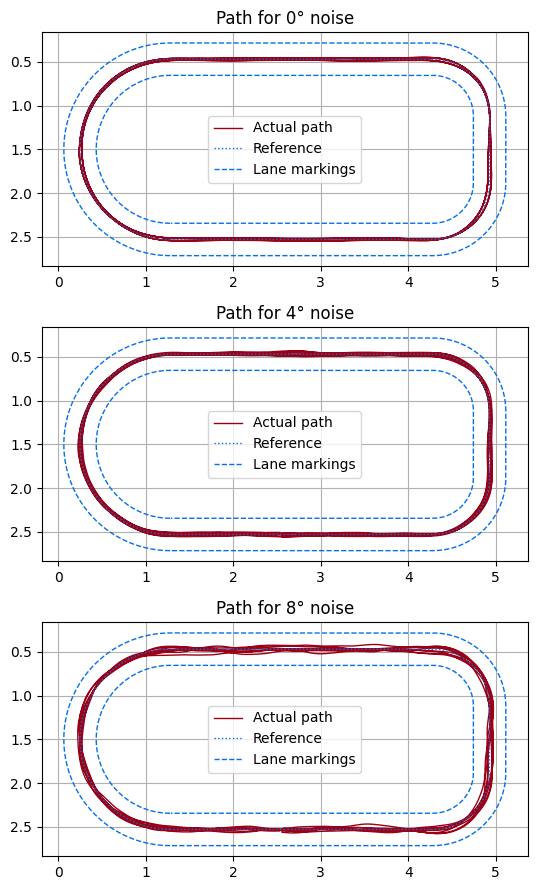

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [4]:
# DATASET ANALYSIS 1
# names = ['cw0', 'cw2', 'cw4', 'cw6', 'cw8', 'cw10', 'cw12', 'cw14', 'acw0', 'acw2', 'acw4', 'acw6', 'acw8', 'acw10', 'acw12', 'acw14']
names = ['cw0', 'cw2', 'cw4', 'cw6', 'cw8', 'cw10', 'acw0', 'acw2', 'acw4', 'acw6', 'acw8', 'acw10']
names = ['cw0', 'cw4','cw8','acw0','acw4','acw8']
folder = 'tmp/real_dss/'
he_dists = [.2,.3,.4,.5,.6,.7,.8,.9]
LEN_NAMES = len(names)

dss = []
for i in tqdm(range(LEN_NAMES//2)):
    name = names[i]
    #keep only the numbers
    val_name = name[2:]
    cw = my_load(folder + names[i] + '.npz')
    acw = my_load(folder + names[i+LEN_NAMES//2] + '.npz')
    cw_imgs, cw_locs = cw['imgs'], cw['locs']
    acw_imgs, acw_locs = acw['imgs'], acw['locs']
    imgs = np.concatenate((cw_imgs, acw_imgs))
    locs = np.concatenate((cw_locs, acw_locs))

    hes = {}
    for he_dist in he_dists:
        cwhe_name = f'tmp/hes/{names[i]}_{he_dist*100:.0f}.npz'
        acwhe_name = f'tmp/hes/{names[i+LEN_NAMES//2]}_{he_dist*100:.0f}.npz'
        cwhe = my_load(cwhe_name)
        acwhe = my_load(acwhe_name)
        cw_hes = cwhe['hes']
        acw_hes = acwhe['hes']
        hes[he_dist] = np.concatenate((cw_hes, acw_hes))

    dss.append({'name': val_name, 'imgs': imgs, 'locs': locs, 'hes': hes})

#simulated version
sim_dss = []
for i in tqdm(range(LEN_NAMES//2)):
    name = names[i]
    #keep only the numbers
    val_name = name[2:]
    cw = my_load(folder + names[i] + '_SIM.npz')
    acw = my_load(folder + names[i+LEN_NAMES//2] + '_SIM.npz')
    cw_imgs, cw_locs = cw['imgs'], cw['locs']
    acw_imgs, acw_locs = acw['imgs'], acw['locs']
    imgs = np.concatenate((cw_imgs, acw_imgs))
    locs = np.concatenate((cw_locs, acw_locs))

    hes = {}
    for he_dist in he_dists:
        cwhe_name = f'tmp/hes/{names[i]}_{he_dist*100:.0f}.npz'
        acwhe_name = f'tmp/hes/{names[i+LEN_NAMES//2]}_{he_dist*100:.0f}.npz'
        cwhe = my_load(cwhe_name)
        acwhe = my_load(acwhe_name)
        cw_hes = cwhe['hes']
        acw_hes = acwhe['hes']
        hes[he_dist] = np.concatenate((cw_hes, acw_hes))

    sim_dss.append({'name': val_name, 'imgs': imgs, 'locs': locs, 'hes': hes})


path = np.load('sparcs/sparcs_path_precise.npy').T
path_int = np.load('sparcs/sparcs_path_int.npy').T
path_ext = np.load('sparcs/sparcs_path_ext.npy').T


#create figure
# fig, ax = plt.subplots(LEN_NAMES//2,1, figsize=(10,14))
fig, ax = plt.subplots(LEN_NAMES//2,1, figsize=(7,9))

for i, ds in enumerate(dss):
    imgs, locs, hes, name = ds['imgs'], ds['locs'], ds['hes'], ds['name']
    #plot
    ax[i].plot(locs[:,1], locs[:,0], label='Actual path', color=C1, linestyle='-', linewidth=1)
    ax[i].grid(True)
    ax[i].set_axisbelow(True)
    ax[i].set_aspect('equal')
    ax[i].plot(path[:,1], path[:,0], label='Reference', color=C2, linestyle=':', linewidth=1)
    ax[i].plot(path_int[:,1], path_int[:,0], label='Lane markings', color=C2, linestyle='--', linewidth=1)
    # ax[i].plot(path_ext[:,1], path_ext[:,0], label='lane (ext)', color=C2, linestyle='--', linewidth=1)
    ax[i].plot(path_ext[:,1], path_ext[:,0], color=C2, linestyle='--', linewidth=1)
    ax[i].set_title(f'Path for {name}° noise')
    ax[i].legend()
    #invert y axis
    ax[i].invert_yaxis()
    # ax[i].set_xlabel('y (m)')
    # ax[i].set_ylabel('x (m)')

#tight layaout
plt.tight_layout()

#show fig
plt.show()

#save figure in vector format
save_fig('dataset_analysis1', fig)


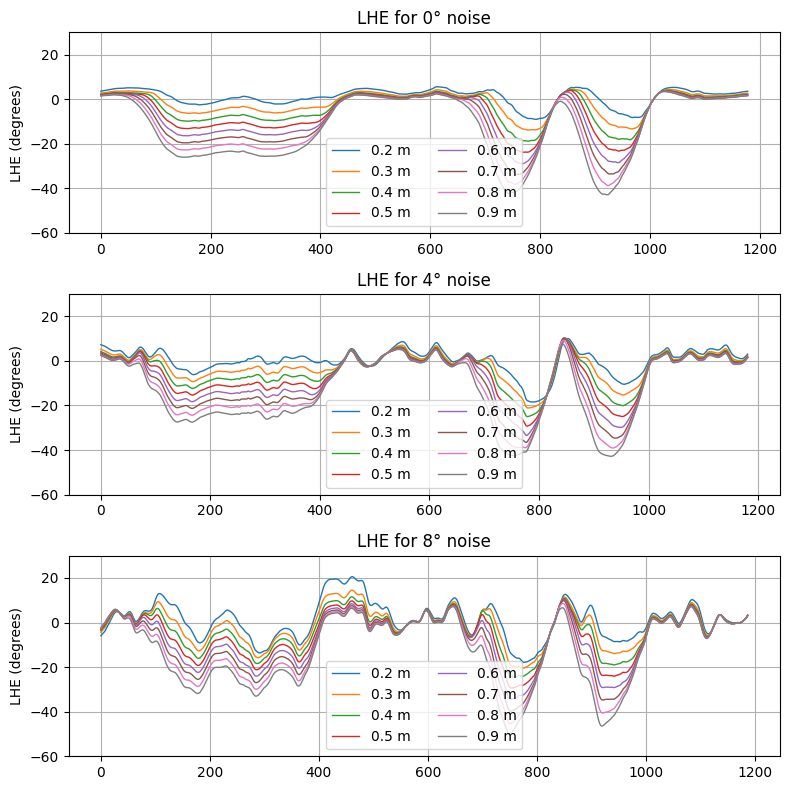

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [3]:
# DATASET ANALYSIS 2
#check dss exists
assert len(dss) > 0

#create figure
fig, ax = plt.subplots(3,1, figsize=(8,8))

for i, ds in enumerate(dss):
    hes, name = ds['hes'], ds['name']
    #select only the first 1/8 of the data
    hes = {k: v[:len(v)//8] for k, v in hes.items()}

    #plot
    for he_dist, he in hes.items():
        he = np.rad2deg(he)
        ax[i].plot(he, label=f'{he_dist} m', linewidth=1)

    ax[i].grid(True)
    ax[i].set_axisbelow(True)
    ax[i].set_title(f'LHE for {name}° noise')
    #set legend with 2 columns
    ax[i].legend(ncol=2)
    # ax[i//2, i%2].legend()
    ax[i].set_ylim(-60, 30)
    # ax[i//2, i%2].set_xlabel('sample')
    ax[i].set_ylabel('LHE (degrees)')

plt.tight_layout()

#show fig
plt.show()

#save figure in vector format
save_fig('dataset_analysis2', fig)



## Network Analysis

In [ ]:
#create useful data
assert len(dss) > 0 and len(sim_dss) > 0
ds = dss[0]
sim_ds = sim_dss[0]
hes = np.rad2deg(ds['hes'][0.6])
# hes = ds['hes'][0.6]
print(hes)
imgs = ds['imgs']
locs = ds['locs']
sim_imgs = sim_ds['imgs']
sim_locs = sim_ds['locs']
print(f'dataset name: {ds["name"]}')

strong_left = None
strong_right = None
weak_left = None
weak_right = None
straight = None

i = 0
while (strong_left is None or strong_right is None or weak_left is None or weak_right is None or straight is None) and i < len(hes):
    if hes[i] < -20 and strong_right is None:
        strong_right = i
    if -6 < hes[i] < -5 and weak_right is None:
        weak_right = i
    if -0.001 < hes[i] < 0.001 and straight is None:
        straight = i
    if 5 < hes[i] < 6 and weak_left is None:
        weak_left = i
    if hes[i] > 20 and strong_left is None:
        strong_left = i    
    i += 1

print(f'strong left: {strong_left}')
print(f'weak left: {weak_left}')
print(f'straight: {straight}')
print(f'weak right: {weak_right}')
print(f'strong right: {strong_right}')


print(f'strong left: {strong_left}, he = {hes[strong_left]:.2f}') 
print(f'weak left: {weak_left}, he = {hes[weak_left]:.2f}')
print(f'straight: {straight}, he = {hes[straight]:.2f}')
print(f'weak right: {weak_right}, he = {hes[weak_right]:.2f}')
print(f'strong right: {strong_right}, he = {hes[strong_right]:.2f}')

img_strong_left_or = imgs[strong_left]
img_weak_left_or = imgs[weak_left]
img_straight_or = imgs[straight]
img_weak_right_or = imgs[weak_right]
img_strong_right_or = imgs[strong_right]

sim_img_strong_left_or = sim_imgs[strong_left]
sim_img_weak_left_or = sim_imgs[weak_left]
sim_img_straight_or = sim_imgs[straight]
sim_img_weak_right_or = sim_imgs[weak_right]
sim_img_strong_right_or = sim_imgs[strong_right]

fig, ax = plt.subplots(5,2, figsize=(10,15))
ax[0,0].imshow(img_strong_left_or, cmap='gray')
ax[1,0].imshow(img_weak_left_or, cmap='gray')
ax[2,0].imshow(img_straight_or, cmap='gray')
ax[3,0].imshow(img_weak_right_or, cmap='gray')
ax[4,0].imshow(img_strong_right_or, cmap='gray')

#preprocess images
img_strong_left = preprocess_image(img_strong_left_or, keep_bottom=0.8)
img_weak_left = preprocess_image(img_weak_left_or, keep_bottom=0.8)
img_straight = preprocess_image(img_straight_or, keep_bottom=0.8)
img_weak_right = preprocess_image(img_weak_right_or, keep_bottom=0.8)
img_strong_right = preprocess_image(img_strong_right_or, keep_bottom=0.8)

ax[0,1].imshow(img_strong_left, cmap='gray')
ax[1,1].imshow(img_weak_left, cmap='gray')
ax[2,1].imshow(img_straight, cmap='gray')
ax[3,1].imshow(img_weak_right, cmap='gray')
ax[4,1].imshow(img_strong_right, cmap='gray')


fig, ax = plt.subplots(5,2, figsize=(10,15))
ax[0,0].imshow(sim_img_strong_left_or, cmap='gray')
ax[1,0].imshow(sim_img_weak_left_or, cmap='gray')
ax[2,0].imshow(sim_img_straight_or, cmap='gray')
ax[3,0].imshow(sim_img_weak_right_or, cmap='gray')
ax[4,0].imshow(sim_img_strong_right_or, cmap='gray')

#preprocess images
sim_img_strong_left = preprocess_image(sim_img_strong_left_or, keep_bottom=0.8)
sim_img_weak_left = preprocess_image(sim_img_weak_left_or, keep_bottom=0.8)
sim_img_straight = preprocess_image(sim_img_straight_or, keep_bottom=0.8)
sim_img_weak_right = preprocess_image(sim_img_weak_right_or, keep_bottom=0.8)
sim_img_strong_right = preprocess_image(sim_img_strong_right_or, keep_bottom=0.8)

ax[0,1].imshow(sim_img_strong_left, cmap='gray')
ax[1,1].imshow(sim_img_weak_left, cmap='gray')
ax[2,1].imshow(sim_img_straight, cmap='gray')
ax[3,1].imshow(sim_img_weak_right, cmap='gray')
ax[4,1].imshow(sim_img_strong_right, cmap='gray')



titles = ['strong left', 'weak left', 'straight', 'weak right', 'strong right']

for i in range(5):
    for j in range(2):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        pass
    #set y label 
    ax[i,0].set_ylabel(titles[i], size='large')

ax[0,0].set_title('original')
ax[0,1].set_title('preprocessed')


plt.tight_layout()

plt.show()

#save figure in vector format
save_fig('turns', fig, dpi=300)

#save images
if not os.path.exists('tmp/random'):
    os.makedirs('tmp/random')
cv.imwrite('tmp/random/strong_left.png', img_strong_left_or)
cv.imwrite('tmp/random/weak_left.png', img_weak_left_or)
cv.imwrite('tmp/random/straight.png', img_straight_or)
cv.imwrite('tmp/random/weak_right.png', img_weak_right_or)
cv.imwrite('tmp/random/strong_right.png', img_strong_right_or)

cv.imwrite('tmp/random/sim_strong_left.png', sim_img_strong_left_or)
cv.imwrite('tmp/random/sim_weak_left.png', sim_img_weak_left_or)
cv.imwrite('tmp/random/sim_straight.png', sim_img_straight_or)
cv.imwrite('tmp/random/sim_weak_right.png', sim_img_weak_right_or)
cv.imwrite('tmp/random/sim_strong_right.png', sim_img_strong_right_or)


In [ ]:
# NETWORK ANALYSIS 

# net_name = 'tmp_bk/models/tr_ds_sn12_he60_canny100_200_blur3_noise80_keep70_size32_length10000_archa_bs65536_lr3000_ep100_L11_L210000_wd90_dr30.pt'
# net_name = 'tmp_bk/models/base_a_32.pt'
# net_name =
# 'tmp/models/tr_ds_sn12_he50_canny100_200_blur3_noise80_keep80_size32_length10000_archa_bs65536_lr5000_ep200_L11000_L210000_wd90_dr40.pt'
net_name = 'Simulator/models/lane_keeper.pt'
net = HEstimator()
net.load_state_dict(torch.load(net_name))

input = img_straight.copy()

assert input.shape == (32, 32)
input = input.reshape(1, 1, 32, 32).astype(np.float32)

input = torch.from_numpy(input)

output = net(input)[0].item()

output = np.rad2deg(output)
print(output)

#load network


In [ ]:
# VISUALIZE CONVOLUTIONAL FILTERS
conv_layers = []
children = list(net.children())
for i in range(len(children)):
    if isinstance(children[i], nn.Conv2d):
        conv_layers.append(children[i])
    elif isinstance(children[i], nn.Sequential):
        for child in children[i].children():
            if isinstance(child, nn.Conv2d):
                conv_layers.append(child)

lin_layers = []
for i in range(len(children)):
    if isinstance(children[i], nn.Linear):
        lin_layers.append(children[i])
    elif isinstance(children[i], nn.Sequential):
        for child in children[i].children():
            if isinstance(child, nn.Linear):
                lin_layers.append(child)

c1 = conv_layers[0].weight.data.cpu().numpy()
c2 = conv_layers[1].weight.data.cpu().numpy()
c3 = conv_layers[2].weight.data.cpu().numpy()

def plot_nchw_data(data, h_num, v_num, title, size=(10, 10)):
    fig, axs = plt.subplots(h_num, v_num, figsize=size)
    shape = data.shape
    data = data.reshape(shape[0]*shape[1], shape[2], shape[3])
    for idx, ax in enumerate(axs.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx < len(data):
            ax.imshow(data[idx,:,:], cmap='gray')
    plt.suptitle(title)
    #plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=0, w_pad=0)
    plt.show()
    return fig

# fig0 = plot_nchw_data(c0, 4, 4, 'conv0')
print(c1.shape)
print(c2.shape)
print(c3.shape)

fig0 = plot_nchw_data(c1, 1, 4, 'conv0', size=(8,2))

fig1 = plot_nchw_data(c2, 4, 4, 'conv1', size=(5,5)) 

fig2 = plot_nchw_data(c3, 8, 8, 'conv2', size=(10,10))







In [ ]:
# MORE CONVOLUTIONAL FILTERS VISUALIZATIONS
from torch.autograd import Variable
from torch.optim import Adam
import copy


conv_output = []
net = HEstimator()


LAYER_NUM = 1
LAYER = net.conv[LAYER_NUM] #net.conv[0,6,11], net.lin[0]
NEURONS = 4
EPOCHS = 500
LR = 5
TITLE = 'First convolutional layer'
SAVE_NAME = '1st_conv_optimal'

# LAYER_NUM = 6
# LAYER = net.conv[LAYER_NUM] #net.conv[0,6,11], net.lin[0]
# NEURONS = 4
# EPOCHS = 500
# LR = 5
# TITLE = 'Second convolutional layer'
# SAVE_NAME = '2nd_conv_optimal'

# LAYER_NUM = 11
# LAYER = net.conv[LAYER_NUM] #net.conv[0,6,11], net.lin[0]
# NEURONS = 32
# EPOCHS = 500
# LR = 5
# TITLE = 'Third convolutional layer'
# SAVE_NAME = '3rd_conv_optimal'


fig, ax = plt.subplots(NEURONS//4, 4, figsize=(10, 3*NEURONS//4))
# fig, ax = plt.subplots(6, 6, figsize=(10, 2*NEURONS//6))

net_name = 'tmp_bk/models/tr_ds_sn12_he60_canny100_200_blur3_noise80_keep70_size32_length10000_archa_bs65536_lr3000_ep100_L11_L210000_wd90_dr30.pt'
# net_name = 'tmp_bk/models/base_a_32.pt'
# net_name = 'tmp/model.pt'
# net_name = 'tmp/models/tr_ds_sn12_he50_canny100_200_blur3_noise80_keep80_size32_length10000_archa_bs65536_lr5000_ep200_L11000_L210000_wd90_dr40.pt'
net_name = 'Simulator/models/lane_keeper.pt'



net.load_state_dict(torch.load(net_name))

net.eval()


def get_img(var):
    y = copy.copy(var.data).numpy()[0][0]
    y = np.clip(y, 0, 255)
    max_val = np.max(y)
    if max_val > 5:
        y = (y * (255/max_val))
    y = np.uint8(y)
    y = cv.resize(y, (320, 320), interpolation=cv.INTER_NEAREST)
    return y

cv.namedWindow('image', cv.WINDOW_NORMAL)
cv.resizeWindow('image', 600, 600)

if NEURONS > 4:
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            ax[i,j].axis('off')

please_break = False
for neuron in range(NEURONS):
    def hook_function(module, grad_in, grad_out):
        global conv_output, neuron
        conv_output = grad_out[0, neuron]
    hook = LAYER.register_forward_hook(hook_function)


    img = np.uint8(np.random.uniform(0, 1, (1,1,32,32))*255)
    # random_image = 255 * np.ones((1, 1, 32, 32), dtype=np.uint8)
    # Process image and return variable
    # x = preprocess_image(random_image, False)
    img = torch.from_numpy(img.astype(np.float32))
    var = Variable(img, requires_grad=True)

    optimizer1 = Adam([var], lr=LR, weight_decay=1e-6)
    optimizer2 = Adam([var], lr=LR/10.0, weight_decay=1e-6)


    for i in range(1, EPOCHS):
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        x = var
        for index, layer in enumerate(net.conv):
            x = layer(x)
            if index == LAYER_NUM:
                break

        # conv_output is updated in hook_function
        loss = -torch.mean(conv_output)
        loss.backward()
        if i < 0.9*EPOCHS:
            optimizer1.step() 
        else:
            optimizer2.step()

        if i % 10 == 0:
            img_to_show = get_img(var)
            cv.imshow('image', img_to_show)
            key = cv.waitKey(1)
            if key == 27:
                please_break = True
                break

    #remove hook
    hook.remove()
    
    if please_break:
        break


    #plot image
    curr_ax = ax[neuron//6, neuron%6] if NEURONS > 4 else ax[neuron]
    curr_ax.imshow(get_img(var), cmap='gray')
    curr_ax.set_xticks([])
    curr_ax.set_yticks([])
    # curr_ax.set_title('Neuron {}'.format(neuron)) 

plt.suptitle(TITLE)
plt.tight_layout()

#save fig
save_fig(SAVE_NAME, fig, dpi=300)

plt.show()
cv.destroyAllWindows()



In [ ]:
print(net)

In [ ]:
# layer activations
intermidiate_outputs = []


imgs = [img_strong_left, img_weak_left, img_straight, img_weak_right, img_strong_right]
or_imgs = [img_strong_left_or, img_weak_left_or, img_straight_or, img_weak_right_or, img_strong_right_or]
img_names = ['strong_left', 'weak_left', 'straight', 'weak_right', 'strong_right']

layer_names = ['1st_conv', '1st_max_pool', '2nd_conv', '2nd_max_pool']#, '3rd_conv']

# #plot imgs
# fig, ax = plt.subplots(2, 5, figsize=(12, 5))
# for i, (img, img_or, name) in enumerate(zip(imgs, or_imgs, img_names)):
#     ax[0][i].imshow(img_or, cmap='gray')
#     ax[0][i].set_title(name)
#     #remove everything but the image
#     ax[0][i].set_xticks([])
#     ax[0][i].set_yticks([])

#     ax[1][i].imshow(img.squeeze(), cmap='gray')
#     #remove everything but the image
#     ax[1][i].set_xticks([])
#     ax[1][i].set_yticks([]) 


# plt.show()

net.eval()

def hook_fn(module, input, output):
    global intermidiate_outputs
    intermidiate_outputs.append(output)

hook_handles = []
hook_handles.append(net.conv[0].register_forward_hook(hook_fn))
hook_handles.append(net.conv[4].register_forward_hook(hook_fn))
hook_handles.append(net.conv[6].register_forward_hook(hook_fn))
hook_handles.append(net.conv[10].register_forward_hook(hook_fn))
# hook_handles.append(net.conv[11].register_forward_hook(hook_fn))

IMG_NUM = 0


or_img = or_imgs[IMG_NUM]
img = imgs[IMG_NUM]
name = img_names[IMG_NUM]
#plot the 2 imgs
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
#set title for entire figure
# fig.suptitle(f'Turn: {name}', fontsize=16)
ax[0].imshow(or_img, cmap='gray')
ax[0].set_title('original')
#remove everything but the image
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(img.squeeze(), cmap='gray')
ax[1].set_title('preprocessed')    
#remove everything but the image
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.tight_layout()
plt.show()  
save_fig(f'or_img_{name}', fig, dpi=100)


img = img[np.newaxis, np.newaxis, :, :]
img = torch.from_numpy(img.astype(np.float32))
with torch.no_grad():
    intermidiate_outputs = []
    out = net(img)

for handle in hook_handles:
    handle.remove()

#plot activations
fig, ax = plt.subplots(len(layer_names), 4, figsize=(12, 12))
for l, (layer_name, layer_output) in enumerate(zip(layer_names, intermidiate_outputs)):
    print(layer_name, layer_output.shape)
    #set title for the entire row
    for i in range(4):
        ax[l][i].set_title(layer_name)
        ax[l][i].set_yticks([])
        ax[l][i].set_xticks([])
        ax[l][i].imshow(layer_output[0, i, :, :], cmap='gray')

# plt.suptitle('Convolutional layer activations', fontsize=16)
plt.tight_layout()
plt.show()
save_fig(f'conv_activations_{name}', fig, dpi=100)



fig, ax = plt.subplots(5, 1, figsize=(12, 12))
for i, (img, name) in enumerate(zip(imgs, img_names)):
    img = img[np.newaxis, np.newaxis, :, :]
    img = torch.from_numpy(img.astype(np.float32))

    #linear layer activations
    intermidiate_outputs = []
    hook_handles = []
    hook_handles.append(net.lin[0].register_forward_hook(hook_fn))


    with torch.no_grad():
        intermidiate_outputs = []
        out = net(img)

    for handle in hook_handles:
        handle.remove()

    # plot bars for the 16 elements in the linear layer
    ax[i].bar(np.arange(16), intermidiate_outputs[0][0, :], color=C1)
    ax[i].set_title(f'fully connected layer activations for {name}')
    ax[i].set_ylim(0,0.3)
    ax[i].set_xticks([])
    ax[i].grid(True, axis='y')
ax[-1].set_xticks(np.arange(16))
plt.show()
    

# fig, ax = plt.subplots(5, 1, figsize=(12, 12))
# for i, (img, name) in enumerate(zip(imgs, img_names)):
#     img = img[np.newaxis, np.newaxis, :, :]
#     img = torch.from_numpy(img.astype(np.float32))

#     #linear layer activations
#     intermidiate_outputs = []
#     hook_handles = []
#     hook_handles.append(net.conv[11].register_forward_hook(hook_fn))


#     with torch.no_grad():
#         intermidiate_outputs = []
#         out = net(img)

#     for handle in hook_handles:
#         handle.remove()

#     intermidiate_outputs = intermidiate_outputs[0].cpu().numpy().reshape(32)

#     # plot bars for the 16 elements in the linear layer
#     ax[i].bar(np.arange(32), intermidiate_outputs, color=C1)
#     ax[i].set_title(f'fully connected layer activations for {name}')
#     ax[i].set_ylim(0,0.15)
#     ax[i].set_xticks([])
#     ax[i].grid(True, axis='y')
# ax[-1].set_xticks(np.arange(32))
# plt.show()





    

## Data preprocessing

In [ ]:
#DATA PREPROCESSING STEPS

#load images
img_strong_left = cv.imread('tmp/random/strong_left.png', cv.IMREAD_GRAYSCALE)
img_weak_left = cv.imread('tmp/random/weak_left.png', cv.IMREAD_GRAYSCALE)
img_straight = cv.imread('tmp/random/straight.png', cv.IMREAD_GRAYSCALE)

sim_img_strong_left = cv.imread('tmp/random/sim_strong_left.png', cv.IMREAD_GRAYSCALE)
sim_img_weak_left = cv.imread('tmp/random/sim_weak_left.png', cv.IMREAD_GRAYSCALE)
sim_img_straight = cv.imread('tmp/random/sim_straight.png', cv.IMREAD_GRAYSCALE)


# imgs = [img_strong_left, img_weak_left, img_straight, sim_img_strong_left, sim_img_weak_left, sim_img_straight]
imgs = [img_strong_left, img_straight, sim_img_strong_left, sim_img_straight]

STEPS = 7

k = 0.4 #0.6

fig, ax = plt.subplots(STEPS, 4, figsize=(k*10, k*STEPS*2.6))
#set title for entire figure
# fig.suptitle('Data Preprocessing', fontsize=16)

#ORIGINAL IMAGES

for i, img in enumerate(imgs):
    ax[0,i].imshow(img, cmap='gray')
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    title = f'Real {i+1}' if i<3 else f'Original'
    ax[0,0].set_ylabel(title)

#RESIZE STEP

for i, img in enumerate(imgs):
    img = cv.resize(img, (4*32, 4*32))
    ax[1,i].imshow(img, cmap='gray')
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[1,0].set_ylabel(f'128x128 Resize')
    imgs[i] = img

#CUT TOP PART
keep_bottom = 0.7
for i, img in enumerate(imgs):
    img = img[int(img.shape[0]*(1-keep_bottom)):,:]
    ax[2,i].imshow(img, cmap='gray')
    ax[2,i].set_xticks([])
    ax[2,i].set_yticks([])
    ax[2,0].set_ylabel(f'Bottom Crop')
    imgs[i] = img

#SECOND RESIZE
for i, img in enumerate(imgs):
    img = cv.resize(img, (2*32, 2*32))
    ax[3,i].imshow(img, cmap='gray')
    ax[3,i].set_xticks([])
    ax[3,i].set_yticks([])
    ax[3,0].set_ylabel(f'64x64 Resize')
    imgs[i] = img

#CANNY
for i, img in enumerate(imgs):
    img = cv.Canny(img, 100, 200)
    ax[4,i].imshow(img, cmap='gray')
    ax[4,i].set_xticks([])
    ax[4,i].set_yticks([])
    ax[4,0].set_ylabel(f'Canny E.D.')
    imgs[i] = img

#BLUR
for i, img in enumerate(imgs):
    img = cv.blur(img, (3,3), 0)
    ax[5,i].imshow(img, cmap='gray')
    ax[5,i].set_xticks([])
    ax[5,i].set_yticks([])
    ax[5,0].set_ylabel(f'G. Blur')
    imgs[i] = img

#THIRD RESIZE
for i, img in enumerate(imgs):
    img = cv.resize(img, (32, 32))
    ax[6,i].imshow(img, cmap='gray')
    ax[6,i].set_xticks([])
    ax[6,i].set_yticks([])
    ax[6,0].set_ylabel(f'32x32 Resize')
    imgs[i] = img

#set x labels for the last raw to sim1, sim2, real1, real2
ax[-1,0].set_xlabel('Real 1')
ax[-1,1].set_xlabel('Real 2')
ax[-1,2].set_xlabel('Sim 1')
ax[-1,3].set_xlabel('Sim 2')

plt.tight_layout()
plt.show()

#save fig
save_fig('data_preprocessing', fig, dpi=300)


In [ ]:
#DATA PREPROCESSING STEPS 6x7 no article

#load images
img_strong_left = cv.imread('tmp/random/strong_left.png', cv.IMREAD_GRAYSCALE)
img_weak_left = cv.imread('tmp/random/weak_left.png', cv.IMREAD_GRAYSCALE)
img_straight = cv.imread('tmp/random/straight.png', cv.IMREAD_GRAYSCALE)

sim_img_strong_left = cv.imread('tmp/random/sim_strong_left.png', cv.IMREAD_GRAYSCALE)
sim_img_weak_left = cv.imread('tmp/random/sim_weak_left.png', cv.IMREAD_GRAYSCALE)
sim_img_straight = cv.imread('tmp/random/sim_straight.png', cv.IMREAD_GRAYSCALE)


imgs = [img_strong_left, img_weak_left, img_straight, sim_img_strong_left, sim_img_weak_left, sim_img_straight]

STEPS = 7

fig, ax = plt.subplots(6, STEPS, figsize=(STEPS*2.5, 12))
#set title for entire figure

#ORIGINAL IMAGES

for i, img in enumerate(imgs):
    ax[i,0].imshow(img, cmap='gray')
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    title = f'real {i+1}' if i<3 else f'simulated {i-2}'
    ax[i,0].set_ylabel(title, size='large')

#RESIZE STEP

for i, img in enumerate(imgs):
    img = cv.resize(img, (4*32, 4*32))
    ax[i,1].imshow(img, cmap='gray')
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])
    imgs[i] = img

#CUT TOP PART
keep_bottom = 0.7
for i, img in enumerate(imgs):
    img = img[int(img.shape[0]*(1-keep_bottom)):,:]
    ax[i,2].imshow(img, cmap='gray')
    ax[i,2].set_xticks([])
    ax[i,2].set_yticks([])
    imgs[i] = img

#SECOND RESIZE
for i, img in enumerate(imgs):
    img = cv.resize(img, (2*32, 2*32))
    ax[i,3].imshow(img, cmap='gray')
    ax[i,3].set_xticks([])
    ax[i,3].set_yticks([])
    imgs[i] = img

#CANNY
for i, img in enumerate(imgs):
    img = cv.Canny(img, 100, 200)
    ax[i,4].imshow(img, cmap='gray')
    ax[i,4].set_xticks([])
    ax[i,4].set_yticks([])
    imgs[i] = img

#BLUR
for i, img in enumerate(imgs):
    img = cv.blur(img, (3,3), 0)
    ax[i,5].imshow(img, cmap='gray')
    ax[i,5].set_xticks([])
    ax[i,5].set_yticks([])
    imgs[i] = img

#THIRD RESIZE
for i, img in enumerate(imgs):
    img = cv.resize(img, (32, 32))
    ax[i,6].imshow(img, cmap='gray')
    ax[i,6].set_xticks([])
    ax[i,6].set_yticks([])
    imgs[i] = img

#titles
ax[0,0].set_title('original image', fontsize=14)
ax[0,1].set_title('initial resize', fontsize=14)
ax[0,2].set_title('cut top 0.3', fontsize=14)
ax[0,3].set_title('first resize', fontsize=14)
ax[0,4].set_title('Canny edge detection', fontsize=14)
ax[0,5].set_title('blur', fontsize=14)
ax[0,6].set_title('second resize', fontsize=14)

# plt.tight_layout()
plt.show()

#save fig
save_fig('data_preprocessing_horizontal', fig, dpi=300)


In [ ]:
# DATA AUGMENTATION STEPS

#load images

sim_img_strong_left = cv.imread('tmp/random/sim_strong_left.png', cv.IMREAD_GRAYSCALE)
sim_img_weak_left = cv.imread('tmp/random/sim_weak_left.png', cv.IMREAD_GRAYSCALE)
sim_img_straight = cv.imread('tmp/random/sim_straight.png', cv.IMREAD_GRAYSCALE)
sim_img_weak_right = cv.imread('tmp/random/sim_weak_right.png', cv.IMREAD_GRAYSCALE)
sim_img_strong_right = cv.imread('tmp/random/sim_strong_right.png', cv.IMREAD_GRAYSCALE)


# imgs = [sim_img_strong_left, sim_img_weak_left, sim_img_straight, sim_img_weak_right, sim_img_strong_right]
imgs = [sim_img_strong_left, sim_img_weak_left, sim_img_straight, sim_img_weak_right]

STEPS = 7
k = .4#.6

fig, ax = plt.subplots(STEPS, 4, figsize=(k*10, k*STEPS*2.6))
#set title for entire figure
# fig.suptitle('Data Augmentation', fontsize=16)

#ORIGINAL IMAGES

for i, img in enumerate(imgs):
    ax[0,i].imshow(img, cmap='gray')
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    title = f'Original'
    ax[0,0].set_ylabel(title)

#RESIZE STEP
size = 32
for i, img in enumerate(imgs):
    img = cv.resize(img, (4*size, 4*size))
    ax[1,i].imshow(img, cmap='gray')
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[1,0].set_ylabel(f'128x128 Resize')
    imgs[i] = img

#ELLIPSES
#create random ellipses to simulate light from the sun
for i, img in enumerate(imgs):

    light = np.zeros(img.shape, dtype=np.uint8)
    #add ellipses
    for j in range(2):
        cent = (randint(0, img.shape[0]), randint(0, img.shape[1]))
        axes_length = (randint(int(4*size/42.67),int(4*size/10.67)), randint(int(4*size/10.67), int(size*4/1.70))) #(randint(3, 12), randint(12, 75))
        angle = randint(0, 360)
        light = cv.ellipse(light, cent, axes_length, angle, 0, 360, 255, -1)
    #create an image of random white and black pixels
    light = cv.blur(light, (50,50))
    noise = randint(0, 2, size=img.shape, dtype=np.uint8)*255
    light = cv.subtract(light, noise)
    light = np.clip(light, 0, 51)
    light *= 5
    #add light to the image
    img = cv.add(img, light)

    ax[2,i].imshow(img, cmap='gray')
    ax[2,i].set_xticks([])
    ax[2,i].set_yticks([])
    ax[2,0].set_ylabel(f'Ellipses')
    imgs[i] = img

#DILATION/EROSION
    
for i, img in enumerate(imgs):
    if i==1:
        #dilate 3
        kernel = np.ones((4,4),np.uint8)
        img = cv.dilate(img,kernel,iterations = 1)
        # ax[3,i].set_title(f'dilate kernel 4x4')
        ax[3,0].set_ylabel(f'Dilate/Erode')
    if i==0:
        #dilate 5
        kernel = np.ones((5,5),np.uint8)
        img = cv.dilate(img,kernel,iterations = 1)
    if i==2:
        pass
    if i==4:
        #erode 5
        kernel = np.ones((4,4),np.uint8)
        img = cv.erode(img,kernel,iterations = 1)
    if i==3:
        #erode 3
        kernel = np.ones((3,3),np.uint8)
        img = cv.erode(img,kernel,iterations = 1)
    ax[3,i].imshow(img, cmap='gray')
    ax[3,i].set_xticks([])
    ax[3,i].set_yticks([])
    imgs[i] = img

#PREPOCESSING

for i, img in enumerate(imgs):
    img = preprocess_image(img)
    ax[4,i].imshow(img, cmap='gray')
    ax[4,i].set_xticks([])
    ax[4,i].set_yticks([])
    ax[4,0].set_ylabel(f'Preproc')
    imgs[i] = img

#TILT
max_tilt_fraction = 0.1
for i, img in enumerate(imgs):
    max_offset = int(size*max_tilt_fraction)
    offset = randint(-max_offset, max_offset)
    img = np.roll(img, offset, axis=0)
    if offset > 0:
        img[:offset, :] = 0 #randint(0,255)
    elif offset < 0:
        img[offset:, :] = 0 # randint(0,255)

    ax[5,i].imshow(img, cmap='gray')
    ax[5,i].set_xticks([])
    ax[5,i].set_yticks([])
    ax[5,0].set_ylabel(f'Tilt')
    imgs[i] = img


#NOISE

for i, img in enumerate(imgs):
    std = 120
    std = randint(1, std)
    noisem = randint(0, std, img.shape, dtype=np.uint8)
    img = cv.subtract(img, noisem)
    noisep = randint(0, std, img.shape, dtype=np.uint8)
    img = cv.add(img, noisep)

    ax[6,i].imshow(img, cmap='gray')
    ax[6,i].set_xticks([])
    ax[6,i].set_yticks([])
    ax[6,0].set_ylabel(f'Noise')
    imgs[i] = img


plt.tight_layout()
plt.show()

save_fig('data_augmentation', fig, dpi=300)



In [ ]:
# DATA SAMPLING

new_ds_path = 'tmp/dss/ds_12.npz'
new_locs = my_load(new_ds_path)['locs']

path = np.load('sparcs/sparcs_path_precise.npy')
path_int = np.load('sparcs/sparcs_path_int.npy')
path_ext = np.load('sparcs/sparcs_path_ext.npy')

#decimate
new_locs = new_locs[::17]

print(new_locs.shape)

new_yaws = new_locs[:, 2] + np.pi/2
nx = new_locs[:, 0]
ny = new_locs[:, 1]
nu = np.cos(new_yaws)
nv = - np.sin(new_yaws)

fig, ax = plt.subplots(1,1, figsize=(8,3.5))
SCALE = 30

ax.plot(path[1,:], path[0,:], color=C2, linewidth=2, label='Centerline')
ax.quiver(ny, nx, nu, nv, color=C1, scale=SCALE)
ax.scatter(ny, nx, color=C1, s=3, label='Samples')
ax.plot(path_ext[1,:], path_ext[0,:], color=C2, linewidth=2, linestyle='dotted', label='Lane markings')
ax.plot(path_int[1,:], path_int[0,:], color=C2, linewidth=2, linestyle='dotted')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xlim(0,3)
ax.set_ylim(0.2, 1.5)
ax.set_aspect('equal')

#set legend
ax.legend(loc='upper right', fontsize=14)

plt.grid()
plt.tight_layout()
plt.show()

save_fig('old_vs_new', fig, dpi=300)


In [ ]:
# ### FULL CONTROL LOOP TEST

# #load .mat file
# import scipy.io as sio
# omat_path = 'tmp/data/proportional/camproportional_0.3_0.5_1.0.mat' #old net
# nmat_path = 'tmp/data/speed/camspeed_0.25_1.00_0.15_0.80.mat' #new net
# nmat = sio.loadmat(nmat_path)
# omat = sio.loadmat(omat_path)

# print(nmat.keys())
# print(omat.keys())

# nlocs = nmat['locs']
# nyaws = nmat['yaws'].reshape(-1)
# olocs = omat['locs']
# oyaws = omat['yaws'].reshape(-1)

# nlheS = np.rad2deg(nmat['lheS'].reshape(-1))
# nlheV = np.rad2deg(nmat['lheV'].reshape(-1))

# olheS = omat['lheS'].reshape(-1)
# olheV = omat['lheV'].reshape(-1)

# print(f'nlheS.shape: {nlheS.shape}')
# print(f'nlheV.shape: {nlheV.shape}')

# print(f'olheS.shape: {olheS.shape}')
# print(f'olheV.shape: {olheV.shape}')


# my_ds_name = 'cw0'
# # my_comb_name = "tr_ds_sn14_he50_canny100_200_blur3_noise80_keep80_size32_length10000_archa_bs65536_lr5000_ep200_L11000_L210000_wd90_dr40"
# my_comb_name = 'tr_ds_sn14_he50_canny100_200_blur3_noise80_keep80_size32_length10000_archa_bs65536_lr5000_ep100_L11000_L210000_wd90_dr40'
# hes, est_hes = get_hes(my_ds_name, my_comb_name)

# print(f'hes.shape: {hes.shape}')
# print(f'est_hes.shape: {est_hes.shape}')

# #keep first quarter
# half = int(hes.shape[0]/2)

# hes = np.rad2deg(np.flip(-hes[:len(hes)//4], axis=0))
# est_hes =  np.rad2deg(np.flip(-est_hes[:len(est_hes)//4], axis=0))




# path = np.load('sparcs/sparcs_path_precise.npy').T

# fig, ax = plt.subplots(1,2, figsize=(10,10))

# ax[1].plot(nlocs[:,0], nlocs[:,1],  label='vehicle path', color=C1)
# ax[1].plot(path[:,0], path[:,1], label='reference path',  color=C2, linestyle='dotted')
# ax[1].set_aspect('equal')

# ax[0].plot(olocs[:,0], olocs[:,1], label='vehicle path', color=C1)
# ax[0].plot(path[:,0], path[:,1], label='reference path',  color=C2, linestyle='dotted')
# ax[0].set_aspect('equal')

# ax[0].set_xlabel('x (m)')
# ax[0].set_ylabel('y (m)')
# ax[1].set_xlabel('x (m)')
# ax[1].set_ylabel('y (m)')

# ax[0].set_title('Trajectory, 0.3 m/s, 0.5  m dist ahead')
# ax[1].set_title('Trajectory, 1.0 m/s, 0.8 m dist ahead')

# ax[1].legend()
# ax[0].legend()

# ax[0].grid()
# ax[1].grid()

# ax[0].set_yticks(np.arange(0, 5.5, 0.5))
# ax[1].set_yticks(np.arange(0, 5.5, 0.5))
# ax[0].set_ylim(0, 5.2)
# ax[1].set_ylim(0, 5.2)


# plt.tight_layout()

# plt.show()

# save_fig('full_control_loop', fig, dpi=10000)


# fig, ax = plt.subplots(2,1, figsize=(10,10))

# ntime = np.arange(nlheS.shape[0])*1/30.0
# otime = np.arange(hes.shape[0])*1/30.0

# ax[1].plot(ntime,nlheS, label='speed', color=C1)
# # ax[1].plot(nlheL, label='lookahead', color=C2)
# ax[1].plot(ntime,nlheV, label='vicon', color=C2)

# # ax[0].plot(olheS, label='estimated', color=C1, linestyle='dotted')
# ax[0].plot(otime, est_hes, label='estimated', color=C1)
# # ax[0].plot(olheL, label='lookahead', color=C2)
# # ax[0].plot(olheV, label='g', color=C2, linestyle='dotted')
# ax[0].plot(otime, hes, label='g', color=C2)

# ax[0].set_xlabel('time (s)')
# ax[0].set_ylabel('Heading error (m)')
# ax[1].set_xlabel('time (s)')
# ax[1].set_ylabel('Heading error (m)')
# ax[0].set_title('HE, low speed, 0.3 m/s, 0.5  m dist ahead')
# ax[1].set_title('HE, high speed, 1.0 m/s, 0.8 m dist ahead')

# ax[1].legend()
# ax[0].legend()

# #grids
# ax[0].grid()
# ax[1].grid()

# ax[0].set_ylim(-10,35)
# ax[1].set_ylim(-10,35)

# ax[0].set_xticks(np.arange(0, otime[-1], 2.5))
# ax[1].set_xticks(np.arange(0, ntime[-1], 2.5))

# plt.tight_layout()

# plt.show()



In [ ]:
# function to align estimates/vicon
def align(est:np.ndarray, vic:np.ndarray):
    #horizonal shifts (integers)
    hss = np.arange(-15, 15, 1)
    #vertical shifts
    vss = np.linspace(-0.5, 0.5, 100)
    #multipliers
    ms = np.linspace(0.4, 0.8, 100)
    #best score
    best_score = np.inf
    bhs, bvs, bm = 0, 0, 1.0
    for hs in tqdm(hss):
        for vs in vss:
            for m in ms:
                temp_est = np.roll(est, hs, axis=0) # horizontal shift
                temp_est = temp_est + vs # vertical shift
                temp_est = temp_est * m
                score = np.sum(np.abs(temp_est - vic)**2)
                if score < best_score:
                    best_score = score
                    bhs, bvs, bm = hs, vs, m
    print(f'best score: {best_score}')
    print(f'best: hs: {bhs}, vs: {bvs}, m: {bm}') 
    best_est = np.roll(est, bhs, axis=0) # horizontal shift
    best_est = best_est + bvs # vertical shift
    best_est = best_est * bm
    return best_est               

dict_keys(['__header__', '__version__', '__globals__', 'time', 'locs', 'yaws', 'lheS', 'lheL', 'lheV'])


100%|██████████| 30/30 [00:02<00:00, 10.89it/s]


best score: 1125.9879037335163
best: hs: 7, vs: -0.1464646464646464, m: 0.5898989898989899
lheS.shape: (442,)
lheV.shape: (442,)


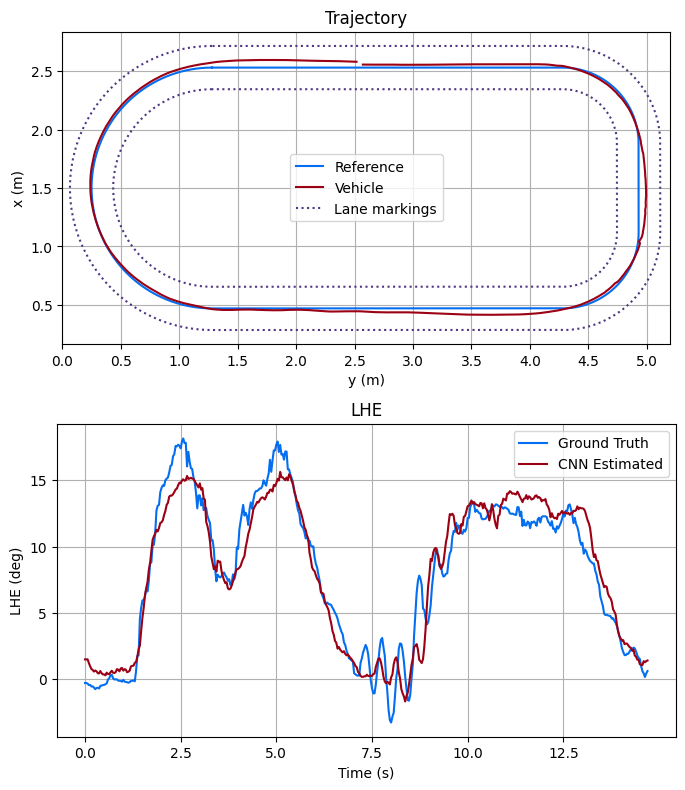

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [ ]:
### FULL CONTROL LOOP TEST
#load .mat file
import scipy.io as sio
# nmat_path = 'tmp/data/speed/camspeed_0.25_1.00_0.15_0.80.mat' #new net
mat_path = 'tmp/data/speed/camspeed_0.40_1.00_0.50_0.50.mat' #new net
mat = sio.loadmat(mat_path)
print(mat.keys())
locs = mat['locs']

lheS = np.rad2deg(mat['lheS'].reshape(-1))
lheV = np.rad2deg(mat['lheV'].reshape(-1))

lheS = align(lheS, lheV)

print(f'lheS.shape: {lheS.shape}')
print(f'lheV.shape: {lheV.shape}')

path = np.load('sparcs/sparcs_path_precise.npy').T
int_path = np.load('sparcs/sparcs_path_int_precise.npy').T
ext_path = np.load('sparcs/sparcs_path_ext_precise.npy').T

ntime = np.arange(lheS.shape[0])*1/30.0

# fig, ax = plt.subplots(2,1, figsize=(8,10))
fig, ax = plt.subplots(2,1, figsize=(7,8))

ax[0].plot(path[:,1], path[:,0], label='Reference',  color=C2)#, linestyle='dotted')
ax[0].plot(locs[:,1], locs[:,0],  label='Vehicle', color=C1)
ax[0].plot(int_path[:,1], int_path[:,0],  color=C3, linestyle='dotted', label='Lane markings')
ax[0].plot(ext_path[:,1], ext_path[:,0],  color=C3, linestyle='dotted')
ax[0].set_aspect('equal')

ax[0].set_xlabel('y (m)')
ax[0].set_ylabel('x (m)')
ax[0].set_title('Trajectory')
ax[0].legend()
ax[0].grid()
ax[0].set_xticks(np.arange(0, 5.5, 0.5))
ax[0].set_xlim(0, 5.2)

ax[1].plot(ntime,lheV, label='Ground Truth', color=C2)
ax[1].plot(ntime,lheS, label='CNN Estimated', color=C1)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('LHE (deg)')
ax[1].set_title('LHE')
ax[1].legend()
ax[1].grid()
# ax[1].set_ylim(-5,20)
ax[1].set_xticks(np.arange(0, ntime[-1], 2.5))
# plt.suptitle('High Speed Test, 1.0 m/s, 0.8 m dist ahead')
plt.tight_layout()
plt.show()

#save
save_fig('high_speed_test', fig, dpi=5000)

In [ ]:
# EXAMPLE IMAGE FROM THE CAMERA
ds_name = 'tmp/real_dss/cw12.npz'
img_save_path = 'thesis_figures/example_img.png'

imgs = my_load(ds_name)['imgs']

cv.namedWindow('image', cv.WINDOW_NORMAL)
cv.resizeWindow('image', 640,480)
for img in imgs:
    cv.imshow('image', img)
    key = cv.waitKey(0)
    if key == 27:
        break
    #check if its the s key
    if key == 115: 
        cv.imwrite(img_save_path, img)
        print('saved')
        break

cv.destroyAllWindows()




In [ ]:
assert False

# PRESENTATION GIFS

In [ ]:
# help functions
import imageio
import os
#create gif folder
if not os.path.exists('gif'):
    os.makedirs('gif/')
if not os.path.exists('gif/tmp'):
    os.makedirs('gif/tmp')


class GifMaker():
    def __init__(self, name, nframes, fps=10, dpi=100, slow=False):
        self.name = name
        self.nframes = nframes
        self.fps = fps
        self.idx = 0
        self.dpi = dpi
        self.frames = []
        self.slow = slow

    def add_frame(self, fig, visualize=False):
        fig.tight_layout()
        #set dpi
        fig.set_dpi(self.dpi)
        fig.canvas.draw()

        if self.slow:
            #save image
            fig.savefig(f'gif/tmp/{self.name}_{self.idx}.jpg')

        width, height = fig.get_size_inches() * fig.get_dpi()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(int(height), int(width), 3)
        
        if not self.slow:
            self.frames.append(img)
        self.idx += 1
        if visualize:
            img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
            cv.imshow('image', img)
            cv.waitKey(1)
    
    def create_gif(self):
        if not self.slow:
            imageio.mimsave(f'gif/{self.name}.gif', self.frames, fps=self.fps)
            print(f'gif/{self.name}.gif created')
        else:
            for i in range(self.idx):
                self.frames.append(imageio.imread(f'gif/tmp/{self.name}_{i}.jpg'))
            imageio.mimsave(f'gif/{self.name}.gif', self.frames, fps=self.fps, )

    def visualize_gif(self):
        from IPython.display import Image
        return Image(f'gif/{self.name}.gif')

FPS = 20
DPI = 90



In [ ]:
# HEADING ERROR EXPL GIF

#load dataset
ds_name = 'cw0'
dist = 70
D = dist / 100.0

npz = my_load(f'tmp/real_dss/{ds_name}.npz')
imgs = npz['imgs']
locs = npz['locs']

print(f' img shape: {imgs[0].shape}')


#load map img
map  = cv.imread('Simulator/src/models_pkg/track/materials/textures/test_VerySmall.png')
print(map.shape)
path = np.load('sparcs/sparcs_path_precise.npy').T + np.array([2.5, 2.5])

# hes = my_load(f'tmp/hes/{ds_name}_{dist}.npz')['hes']
locsr = np.array([np.array(com2rear(loc[0], loc[1], loc[2])) for loc in locs])
hes = np.array([get_heading_error(xr+2.5,yr+2.5,yaw, path[::50, :], D)[0] for xr,yr,yaw in locsr])
print(f'hes shape: {hes.shape}')

#decimate path
path = path[::500, :]
print(f'path.shape: {path.shape}')

cv.namedWindow('map', cv.WINDOW_NORMAL)
cv.resizeWindow('map', 500, 500)

#select first lap, first quarter
hes = hes[:len(hes)//4]
imgs = imgs[:len(imgs)//4]
locs = locs[:len(locs)//4]

#decimate
dec = 3
hes = hes[::dec]
imgs = imgs[::dec]
locs = locs[::dec]

print(f'len: {len(hes)}')
gif = GifMaker('heading_error', len(hes), fps=FPS, dpi=DPI)

CV3 = (C2_CV[0]//2, C2_CV[1]//2, C2_CV[2]//2)
#draw path on map
for p in path:
    map = cv.circle(map, mR2pix(p), 3, CV3, -1)

cv.namedWindow('start_map', cv.WINDOW_NORMAL)
cv.resizeWindow('start_map', 500, 500)
cv.imshow('start_map', map)


for i, (img, loc, he) in tqdm(enumerate(zip(imgs, locs, hes)), total=len(hes)):
    x,y,yaw = loc[0]+2.5, loc[1]+2.5, loc[2]    

    #convert img 2 bgr
    img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)

    p = np.array([x,y])
    xr, yr, _ = com2rear(x,y,yaw)
    xc, yc = x + 0.3*np.cos(yaw), y + 0.3*np.sin(yaw)
    pr = np.array([xr,yr])
    pixr = mR2pix(pr)
    pix = mR2pix(p)
    pixc = mR2pix(np.array([xc,yc]))


    tmp_map = map.copy()

    #car
    tmp_map = draw_car(tmp_map, x,y,yaw, color=C1_CV)
    #rear axis
    tmp_map = cv.circle(tmp_map, pixr, 5, C1_CV, -1)
    #p ahead
    pa = pr + D*np.array([np.cos(yaw+he), np.sin(yaw+he)])
    pa2 = pr + D*np.array([np.cos(yaw+he), np.sin(yaw+he)])/2
    pixa = mR2pix(pa)
    pixa2 = mR2pix(pa2)
    tmp_map = cv.circle(tmp_map, pixa, 3, C2_CV, -1)

    # p proj
    pp = pr + D*np.array([np.cos(yaw), np.sin(yaw)])
    pp2 = pr + D*np.array([np.cos(yaw), np.sin(yaw)])/2
    pixp = mR2pix(pp)
    pixp2 = mR2pix(pp2)
    tmp_map = cv.circle(tmp_map, pixp, 3, C2_CV, -1)

    #segments
    tmp_map = cv.line(tmp_map, pixr, pixa, C2_CV, 2)
    tmp_map = cv.line(tmp_map, pixr, pixp, C2_CV, 2)
    tmp_map = cv.drawContours(tmp_map, [np.array([pixr, pixa2, pixp2])], 0, C2_CV, -1)

    #project path onto frame
    img, _ = project_onto_frame2(img, path, x, y, yaw, color=CV3, thickness=1)

    img, proja = project_onto_frame2(img, pa, x, y, yaw, color=C2_CV, thickness=2)
    img, projp = project_onto_frame2(img, pp, x, y, yaw, color=C2_CV, thickness=2)

    # proj0 = (img.shape[0]//2, img.shape[1]-1)
    proj0 = (img.shape[1]//2, img.shape[0]+120)

    

    img = cv.line(img, proj0, (int(proja[0]), int(proja[1])), C2_CV, 1)
    img = cv.line(img, proj0, (int(projp[0]), int(projp[1])), C2_CV, 1)


    cv.imshow('map', tmp_map)
    cv.waitKey(1)

    #get a square around xp, yp
    size = 300
    xp, yp = pixc[0], pixc[1]
    tmp_map = tmp_map[yp-size:yp+size, xp-size:xp+size]


    tmp_map = cv.resize(tmp_map, (300,300))

    tmp_map = cv.cvtColor(tmp_map, cv.COLOR_BGR2RGB)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1,2, figsize=(12,5))
    ax[0].imshow(img)
    ax[0].set_title(f'Heading error: {np.rad2deg(he):.2f} deg')
    ax[0].axis('off')

    ax[1].imshow(tmp_map)
    ax[1].set_title('Top down view')
    ax[1].axis('off')


    plt.tight_layout()
   
    gif.add_frame(fig, visualize=True)

    plt.close(fig)
cv.destroyAllWindows()


#create gif
gif.create_gif()

#visualize gif
# gif.visualize_gif()


In [ ]:
# DATA COLLECTION STEER NOISE LEVEL GIF
dist = 0.5

ds0_name = '0'
ds1_name = '6'
ds2_name = '14'

locs0 = my_load(f'tmp/dss/ds_{ds0_name}.npz')['locs']
locs1 = my_load(f'tmp/dss/ds_{ds1_name}.npz')['locs']
locs2 = my_load(f'tmp/dss/ds_{ds2_name}.npz')['locs']

imgs0 = my_load(f'tmp/dss/ds_{ds0_name}.npz')['imgs']
imgs1 = my_load(f'tmp/dss/ds_{ds1_name}.npz')['imgs']
imgs2 = my_load(f'tmp/dss/ds_{ds2_name}.npz')['imgs']

hes0 = my_load(f'tmp/hes/hes_{ds0_name}_{dist*100:.0f}.npz')['hes']
hes1 = my_load(f'tmp/hes/hes_{ds1_name}_{dist*100:.0f}.npz')['hes']
hes2 = my_load(f'tmp/hes/hes_{ds2_name}_{dist*100:.0f}.npz')['hes']

path = np.load('sparcs/sparcs_path_precise.npy').T
int_path = np.load('sparcs/sparcs_path_int_precise.npy').T
ext_path = np.load('sparcs/sparcs_path_ext_precise.npy').T
dec_path = 500
path = path[::dec_path]
int_path = int_path[::dec_path]
ext_path = ext_path[::dec_path]

dec_loc = 50
locs0 = locs0[::dec_loc]
locs1 = locs1[::dec_loc]
locs2 = locs2[::dec_loc]
imgs0 = imgs0[::dec_loc]
imgs1 = imgs1[::dec_loc]
imgs2 = imgs2[::dec_loc]
hes0 = hes0[::dec_loc]
hes1 = hes1[::dec_loc]
hes2 = hes2[::dec_loc]

x0s = locs0[:,0]
x1s = locs1[:,0]
x2s = locs2[:,0]
y0s = locs0[:,1]
y1s = locs1[:,1]
y2s = locs2[:,1]
yaw0s = locs0[:,2]
yaw1s = locs1[:,2]
yaw2s = locs2[:,2]

u0s = np.cos(yaw0s)
v0s = np.sin(yaw0s)
u1s = np.cos(yaw1s)
v1s = np.sin(yaw1s)
u2s = np.cos(yaw2s)
v2s = np.sin(yaw2s)

# idx = 50
step = 1


gif = GifMaker('ds_steer_noise', len(locs0)//step, fps=8, dpi=100*1.5)

for idx in tqdm(range(0, len(locs0), step)):

    fig, ax = plt.subplots(2,3, figsize=(12,9), gridspec_kw={'height_ratios': [3, 1]})
    SCALE = 20
    ax[0,0].quiver(x0s, y0s, u0s, v0s, color=C1, scale=SCALE)
    ax[0,0].plot(path[:,0], path[:,1],  color=C2, linewidth=2, linestyle='dotted')
    ax[0,0].plot(int_path[:,0], int_path[:,1],  color=C2, linewidth=2, linestyle='dotted')
    ax[0,0].plot(ext_path[:,0], ext_path[:,1],  color=C2, linewidth=2, linestyle='dotted')
    ax[0,0].set_aspect('equal')
    ax[0,0].set_xlabel('x (m)')
    ax[0,0].set_ylabel('y (m)')
    ax[0,0].set_xlim(0, 3)
    ax[0,0].set_ylim(0, 5.3)
    ax[0,0].set_xticks(np.arange(0, 3.1, 0.5))
    ax[0,0].set_yticks(np.arange(0, 5.4, 0.5))
    ax[0,0].grid()
    ax[0,0].set_axisbelow(True)

    ax[0,1].quiver(x1s, y1s, u1s, v1s, color=C1, scale=SCALE)
    ax[0,1].plot(path[:,0], path[:,1],  color=C2, linewidth=2, linestyle='dotted')
    ax[0,1].plot(int_path[:,0], int_path[:,1],  color=C2, linewidth=2, linestyle='dotted')
    ax[0,1].plot(ext_path[:,0], ext_path[:,1],  color=C2, linewidth=2, linestyle='dotted')
    ax[0,1].set_aspect('equal')
    ax[0,1].set_xlabel('x (m)')
    ax[0,1].set_ylabel('y (m)')
    ax[0,1].set_xlim(0, 3)
    ax[0,1].set_ylim(0, 5.3)
    ax[0,1].set_xticks(np.arange(0, 3.1, 0.5))
    ax[0,1].set_yticks(np.arange(0, 5.4, 0.5))
    ax[0,1].grid()
    ax[0,1].set_axisbelow(True)

    ax[0,2].quiver(x2s, y2s, u2s, v2s, color=C1, scale=SCALE)
    ax[0,2].plot(path[:,0], path[:,1],  color=C2, linewidth=2, linestyle='dotted')    
    ax[0,2].plot(int_path[:,0], int_path[:,1],  color=C2, linewidth=2, linestyle='dotted')
    ax[0,2].plot(ext_path[:,0], ext_path[:,1],  color=C2, linewidth=2, linestyle='dotted')
    ax[0,2].set_aspect('equal')
    ax[0,2].set_xlabel('x (m)')
    ax[0,2].set_ylabel('y (m)')
    ax[0,2].set_xlim(0, 3)
    ax[0,2].set_ylim(0, 5.3)
    ax[0,2].set_xticks(np.arange(0, 3.1, 0.5))
    ax[0,2].set_yticks(np.arange(0, 5.4, 0.5))
    ax[0,2].grid()
    ax[0,2].set_axisbelow(True)

    x0, y0, yaw0, u0, v0, he0 = x0s[idx], y0s[idx], yaw0s[idx], u0s[idx], v0s[idx], hes0[idx]
    x1, y1, yaw1, u1, v1, he1 = x1s[idx], y1s[idx], yaw1s[idx], u1s[idx], v1s[idx], hes1[idx]
    x2, y2, yaw2, u2, v2, he2 = x2s[idx], y2s[idx], yaw2s[idx], u2s[idx], v2s[idx], hes2[idx]
    projR = (imgs0[0].shape[1]//2, imgs0.shape[0]+120)
    #IMGS

    img0 = imgs0[idx].copy()
    img0 = cv.cvtColor(img0, cv.COLOR_GRAY2BGR) 
    pa0 = np.array([x0,y0]) + np.array([np.cos(yaw0+he0), np.sin(yaw0+he0)])*dist
    img0, proj0 = project_onto_frame2(img0, pa0, x0, y0, yaw0)
    if proj0 is not None:
        img0 = cv.line(img0, projR, (int(proj0[0]), int(proj0[1])), C2_CV, 5)

    img1 = imgs1[idx].copy()
    img1 = cv.cvtColor(img1, cv.COLOR_GRAY2BGR)
    pa1 = np.array([x1,y1]) + np.array([np.cos(yaw1+he1), np.sin(yaw1+he1)])*dist
    img1, proj1 = project_onto_frame2(img1, pa1, x1, y1, yaw1)
    if proj1 is not None:
        img1 = cv.line(img1, projR, (int(proj1[0]), int(proj1[1])), C2_CV, 5)

    img2 = imgs2[idx].copy()
    img2 = cv.cvtColor(img2, cv.COLOR_GRAY2BGR)
    pa2 = np.array([x2,y2]) + np.array([np.cos(yaw2+he2), np.sin(yaw2+he2)])*dist
    img2, proj2 = project_onto_frame2(img2, pa2, x2, y2, yaw2)
    if proj2 is not None:
        img2 = cv.line(img2, projR, (int(proj2[0]), int(proj2[1])), C2_CV, 5)


    img0 = cv.cvtColor(img0, cv.COLOR_BGR2RGB)
    ax[1,0].imshow(img0)
    ax[1,0].axis('off')

    img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
    ax[1,1].imshow(img1)
    ax[1,1].axis('off')

    img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
    ax[1,2].imshow(img2)
    ax[1,2].axis('off')

    SCALE2 = 0.25
    ax[0,0].arrow(x0, y0, u0*SCALE2, v0*SCALE2, color=C1, width=0.04, head_width=0.1, head_length=0.1, zorder=5)
    ax[0,1].arrow(x1, y1, u1*SCALE2, v1*SCALE2, color=C1, width=0.04, head_width=0.1, head_length=0.1, zorder=5)
    ax[0,2].arrow(x2, y2, u2*SCALE2, v2*SCALE2, color=C1, width=0.04, head_width=0.1, head_length=0.1, zorder=5)

    SCALE3 = 1.0*dist
    ax[0,0].arrow(x0, y0, np.cos(yaw0+he0)*SCALE3, np.sin(yaw0+he0)*SCALE3, color=C2, width=0.04, head_width=0.1, head_length=0.1, zorder=4)
    ax[0,1].arrow(x1, y1, np.cos(yaw1+he1)*SCALE3, np.sin(yaw1+he1)*SCALE3, color=C2, width=0.04, head_width=0.1, head_length=0.1, zorder=4)
    ax[0,2].arrow(x2, y2, np.cos(yaw2+he2)*SCALE3, np.sin(yaw2+he2)*SCALE3, color=C2, width=0.04, head_width=0.1, head_length=0.1, zorder=4)


    #gif
    plt.tight_layout()
    gif.add_frame(fig)

    plt.close(fig)

gif.create_gif()

    



In [ ]:
# PREPROCESSING AND AUGMENTATION GIF
#just use the thesis image

In [ ]:
# NETWORK VISUALIZATION GIF

#load dataset
ds_name = 'cw0'
dist = 70
D = dist / 100.0

npz = my_load(f'tmp/real_dss/{ds_name}.npz')
imgs = npz['imgs']
locs = npz['locs']

#load map img
map  = cv.imread('Simulator/src/models_pkg/track/materials/textures/test_VerySmall.png')
print(map.shape)
path = np.load('sparcs/sparcs_path_precise.npy').T + np.array([2.5, 2.5])

# hes = my_load(f'tmp/hes/{ds_name}_{dist}.npz')['hes']
locsr = np.array([np.array(com2rear(loc[0], loc[1], loc[2])) for loc in locs])
hes = np.array([get_heading_error(xr+2.5,yr+2.5,yaw, path[::50, :], D)[0] for xr,yr,yaw in locsr])

ds2_name = 'acw0'
npz2 = my_load(f'tmp/real_dss/{ds2_name}.npz')
imgs2 = npz2['imgs']
locs2 = npz2['locs']
locsr2 = np.array([np.array(com2rear(loc[0], loc[1], loc[2])) for loc in locs2])
hes2 = np.array([get_heading_error(xr+2.5,yr+2.5,yaw, path[::50, :], D)[0] for xr,yr,yaw in locsr2])


#decimate path
path = path[::500, :]
print(f'path.shape: {path.shape}')

cv.namedWindow('map', cv.WINDOW_NORMAL)
cv.resizeWindow('map', 500, 500)

#select first lap, first quarter
hes = hes[:len(hes)//4]
imgs = imgs[:len(imgs)//4]
locs = locs[:len(locs)//4]

hes2 = hes2[:len(hes2)//4]
imgs2 = imgs2[:len(imgs2)//4]
locs2 = locs2[:len(locs2)//4]


#decimate
dec = 7
hes = hes[::dec]
imgs = imgs[::dec]
locs = locs[::dec]

hes2 = hes2[::dec]
imgs2 = imgs2[::dec]
locs2 = locs2[::dec]

#concatenate
hes = np.concatenate((hes, hes2))
imgs = np.concatenate((imgs, imgs2))
locs = np.concatenate((locs, locs2))


net_name = 'tmp_bk/models/tr_ds_sn12_he60_canny100_200_blur3_noise80_keep70_size32_length10000_archa_bs65536_lr3000_ep100_L11_L210000_wd90_dr30.pt'
# net_name = 'tmp_bk/models/base_a_32.pt'
# net_name =
# 'tmp/models/tr_ds_sn12_he50_canny100_200_blur3_noise80_keep80_size32_length10000_archa_bs65536_lr5000_ep200_L11000_L210000_wd90_dr40.pt'
# net_name = 'Simulator/models/lane_keeper.pt'
net = HEstimator()
net.load_state_dict(torch.load(net_name))

# layer activations
layer_names = ['1st_conv', '1st_max_pool', '2nd_conv', '2nd_max_pool']#, '3rd_conv']

N = len(imgs)
gif = GifMaker('activations',N, fps=15, dpi=DPI)

for idx in tqdm(range(N)):


    intermidiate_outputs = []
    net.eval()

    def hook_fn(module, input, output):
        global intermidiate_outputs
        intermidiate_outputs.append(output)

    hook_handles = []
    hook_handles.append(net.conv[0].register_forward_hook(hook_fn))
    hook_handles.append(net.conv[4].register_forward_hook(hook_fn))
    hook_handles.append(net.conv[6].register_forward_hook(hook_fn))
    hook_handles.append(net.conv[10].register_forward_hook(hook_fn))
    # hook_handles.append(net.conv[11].register_forward_hook(hook_fn))


    fig = plt.figure(constrained_layout=True, figsize=(16, 9))
    axd = fig.subplot_mosaic(
        """
        sabcdv
        sefghv
        tilmnv
        uopqrv
        """,
        gridspec_kw={'width_ratios': [2,1,1,1,1,1]})


    #show images
    or_img = imgs[idx].copy()
    img = preprocess_image(imgs[idx].copy())
    #plot
    axd['s'].imshow(or_img, cmap='gray')
    axd['s'].set_title('original')
    #remove everything but the image
    axd['s'].set_xticks([])
    axd['s'].set_yticks([])
    axd['t'].imshow(img.squeeze(), cmap='gray')
    axd['t'].set_title('preprocessed')    
    #remove everything but the image
    axd['t'].set_xticks([])
    axd['t'].set_yticks([])

    img = img[np.newaxis, np.newaxis, :, :]
    img = torch.from_numpy(img.astype(np.float32))
    out = None
    with torch.no_grad():
        intermidiate_outputs = []
        out = net(img)
        out = out.detach().numpy()
        out = out[0]
        out = np.rad2deg(out)

    out = np.array([-out, -np.rad2deg(hes[idx])])
    #horizontal bar plot out on axd['u']
    axd['u'].barh(np.arange(2), out, color=C1)
    axd['u'].set_title('final output')
    axd['u'].set_yticks([])
    axd['u'].set_xlim(-40, 40)
    axd['u'].set_xlabel('degrees')
    axd['u'].set_yticks(np.arange(2), ('estimated', 'ground truth'))
    axd['u'].grid(True)
    axd['u'].set_axisbelow(True)

    for handle in hook_handles:
        handle.remove()

    ax16 = [['a', 'b', 'c', 'd'], ['e', 'f', 'g', 'h'], ['i', 'l', 'm', 'n'], ['o', 'p', 'q', 'r']]

    #plot activations
    for l, (layer_name, layer_output) in enumerate(zip(layer_names, intermidiate_outputs)):
        #set title for the entire row
        for i in range(4):
            ax = axd[ax16[l][i]]
            ax.set_title(f'{layer_name} {i+1}')
            ax.set_yticks([])
            ax.set_xticks([])
            ax.imshow(layer_output[0, i, :, :], cmap='gray')

    #linear layer activations
    intermidiate_outputs = []
    hook_handles = []
    hook_handles.append(net.lin[0].register_forward_hook(hook_fn))

    with torch.no_grad():
        intermidiate_outputs = []
        out = net(img)

    for handle in hook_handles:
        handle.remove()

    # plot bars for the 16 elements in the linear layer
    axd['v'].barh(np.arange(16), intermidiate_outputs[0][0, :], color=C1)
    axd['v'].set_xlim(0,0.3)
    axd['v'].set_yticks([])
    axd['v'].grid(True, axis='x')
    axd['v'].set_yticks(np.arange(16))
    axd['v'].set_title('linear layer')
    #axis below
    axd['v'].set_axisbelow(True)

    #save gif
    plt.tight_layout()
    gif.add_frame(fig)
    plt.close(fig)

#create gif
gif.create_gif()


    


    


In [ ]:
# FINAL CONTROL LOOP VISUALIZATION GIF

### FULL CONTROL LOOP TEST
#load .mat file
import scipy.io as sio
# omat_path = 'tmp/camproportional_0.3_0.5_1.0.mat' #old net
nmat_path = 'tmp/camspeed_0.25_1.00_0.15_0.80.mat' #new net
# omat = sio.loadmat(omat_path)
nmat = sio.loadmat(nmat_path)

print(nmat.keys())
# print(omat.keys())

nlocs = nmat['locs']
nyaws = nmat['yaws'].reshape(-1)
# olocs = omat['locs']
# oyaws = omat['yaws'].reshape(-1)

nlheS = np.rad2deg(nmat['lheS'].reshape(-1))
nlheV = np.rad2deg(nmat['lheV'].reshape(-1))

# olheS = omat['lheS'].reshape(-1)
# olheV = omat['lheV'].reshape(-1)

print(f'nlheS.shape: {nlheS.shape}')
print(f'nlheV.shape: {nlheV.shape}')

# print(f'olheS.shape: {olheS.shape}')
# print(f'olheV.shape: {olheV.shape}')
DO = 0.5
DN = 0.8

my_ds_name = 'cw0'
my_comb_name = "tr_ds_sn14_he50_canny100_200_blur3_noise80_keep80_size32_length10000_archa_bs65536_lr5000_ep200_L11000_L210000_wd90_dr40"
hes, est_hes = get_hes(my_ds_name, my_comb_name)
locs = my_load(f'tmp/real_dss/{my_ds_name}.npz')['locs']


print(f'hes.shape: {hes.shape}')
print(f'est_hes.shape: {est_hes.shape}')

#keep first quarter
half = int(hes.shape[0]/2)

hes = np.rad2deg(np.flip(-hes[:len(hes)//4], axis=0))
est_hes =  np.rad2deg(np.flip(-est_hes[:len(est_hes)//4], axis=0))
locs = np.flip(locs[:len(locs)//4], axis=0)
olocs = locs[:, :2]
oyaws = locs[:, 2] - np.pi

path = np.load('sparcs/sparcs_path_precise.npy').T
int_path = np.load('sparcs/sparcs_path_int_precise.npy').T
ext_path = np.load('sparcs/sparcs_path_ext_precise.npy').T

ntime = np.arange(nlheS.shape[0])*1/30.0
otime = np.arange(hes.shape[0])*1/30.0

# tmp_hes = hes.copy()
# shifts = np.arange(-60, -10, 1)
# avg_dists_shift = []
# for shift in tqdm(shifts):
#     tmp_hes2 = np.roll(tmp_hes, shift, axis=0)
#     pas = olocs + np.stack([np.cos(oyaws+tmp_hes2)*0.5, np.sin(oyaws+tmp_hes2)*0.5], axis=1)
#     assert pas.shape == olocs.shape
#     min_dists = []
#     for pa in pas:
#         min_dist = np.min(np.linalg.norm(path-pa, axis=1))
#         min_dists.append(min_dist)
#     min_dists = np.array(min_dists)
#     #avg dist 
#     avg_dist = np.sum(min_dists)
#     avg_dists_shift.append(avg_dist)

# avg_dists_shift = np.array(avg_dists_shift)
# best_shift = shifts[np.argmin(avg_dists_shift)]
# print(f'best_shift: {best_shift}')




#roll hes and est ess
roll = -30#-32#-55# -30
hes = np.roll(hes, roll)
est_hes = np.roll(est_hes, roll)

or_ntime = ntime.copy()
or_nlheS = nlheS.copy()
or_nlheV = nlheV.copy()
or_nlocs = nlocs.copy()
or_nyaws = nyaws.copy()

or_otime = otime.copy()
or_hes = hes.copy()
or_est_hes = est_hes.copy()
or_olocs = olocs.copy()
or_oyaws = oyaws.copy()


#decimate
dec = 2
ntime = ntime[::dec]
nlheS = nlheS[::dec]
nlheV = nlheV[::dec]
nlocs = nlocs[::dec]
nyaws = nyaws[::dec]

otime = otime[::dec]
hes = hes[::dec]
est_hes = est_hes[::dec]
olocs = olocs[::dec]
oyaws = oyaws[::dec]


fps = 22.5
dpi = 100

gif = GifMaker('final_test_slow', len(otime), fps=fps, dpi=dpi)


## SLOW SPEED
for idx in tqdm(range(len(otime))):

    fig, ax = plt.subplots(1,2, figsize=(14,7))
    ax[0].plot(or_olocs[:,0], or_olocs[:,1], label='vehicle trajectory', color=C1)
    ax[0].plot(path[:,0], path[:,1], label='reference trajectory',  color=C2, linestyle='dotted')
    ax[0].plot(int_path[:,0], int_path[:,1],  color=C3, linestyle='dotted')
    ax[0].plot(ext_path[:,0], ext_path[:,1],  color=C3, linestyle='dotted')
    ax[0].set_aspect('equal')

    ax[0].set_xlabel('x (m)')
    ax[0].set_ylabel('y (m)')

    ax[0].set_title('Trajectory')
    ax[0].legend()
    ax[0].grid()
    ax[0].set_yticks(np.arange(0, 5.5, 0.5))
    ax[0].set_ylim(0, 5.2)

    ax[1].plot(or_otime, or_hes, label='ground truth', color=C2)
    ax[1].plot(or_otime, or_est_hes, label='estimated', color=C1)
    ax[1].set_xlabel('time (s)')
    ax[1].set_ylabel('Heading error (m)')
    ax[1].set_title('Heading error')
    ax[1].legend()
    ax[1].grid()
    ax[1].set_axisbelow(True)
    ax[1].set_ylim(-10,35)
    ax[1].set_xticks(np.arange(0, otime[-1], 2.5))

    plt.suptitle('Low speed test, 0.3 m/s, 0.5  m dist ahead', fontsize=16)


    #arrows
    x0, y0, yaw0, he0, est_he0, t0 = olocs[idx,0], olocs[idx,1], oyaws[idx], np.deg2rad(hes[idx]), np.deg2rad(est_hes[idx]), otime[idx]
    SCALE2 = 0.2
    ax[0].arrow(x0, y0, np.cos(yaw0)*SCALE2, np.sin(yaw0)*SCALE2, color=C3, width=0.02, head_width=0.1, head_length=0.1, zorder=5)

    SCALE3 = 1.0*DO
    ax[0].arrow(x0, y0, np.cos(yaw0+he0)*SCALE3, np.sin(yaw0+he0)*SCALE3, color=C2, width=0.05, head_width=0.15, head_length=0.15, zorder=4)
    ax[0].arrow(x0, y0, np.cos(yaw0+est_he0)*SCALE3, np.sin(yaw0+est_he0)*SCALE3, color=C1, width=0.02, head_width=0.1, head_length=0.1, zorder=4)

    ax[1].plot(t0, np.rad2deg(he0), 'o', color=C2, zorder=4, markersize=10 )
    ax[1].plot(t0, np.rad2deg(est_he0), 'o', color=C1, zorder=4, markersize=10 )

    plt.tight_layout()
    gif.add_frame(fig)
    plt.close(fig)

gif.create_gif()



## FAST SPEED

gif = GifMaker('final_test_fast', len(ntime), fps=fps, dpi=dpi)
for idx in tqdm(range(len(ntime))):

    fig, ax = plt.subplots(1,2, figsize=(14,7))

    ax[0].plot(or_nlocs[:,0], or_nlocs[:,1],  label='vehicle trajectory', color=C1)
    ax[0].plot(path[:,0], path[:,1], label='reference trajectory',  color=C2, linestyle='dotted')
    ax[0].plot(int_path[:,0], int_path[:,1],  color=C3, linestyle='dotted')
    ax[0].plot(ext_path[:,0], ext_path[:,1],  color=C3, linestyle='dotted')
    ax[0].set_aspect('equal')

    ax[0].set_ylabel('y (m)')
    ax[0].set_xlabel('x (m)')
    ax[0].set_title('Trajectory')
    ax[0].legend()
    ax[0].grid()
    ax[0].set_yticks(np.arange(0, 5.5, 0.5))
    ax[0].set_ylim(0, 5.2)

    ax[1].plot(or_ntime,or_nlheV, label='ground truth', color=C2)
    ax[1].plot(or_ntime,or_nlheS, label='estimated', color=C1)
    ax[1].set_xlabel('time (s)')
    ax[1].set_ylabel('Heading error (m)')
    ax[1].set_title('Heading error')
    ax[1].legend()
    ax[1].grid()
    ax[1].set_axisbelow(True)
    ax[1].set_ylim(-10,35)
    ax[1].set_xticks(np.arange(0, ntime[-1], 2.5))

    plt.suptitle('High speed test, 1.0 m/s, 0.8 m dist ahead', fontsize=16)

    #arrows
    x0, y0, yaw0, he0, est_he0, t0 = nlocs[idx,0], nlocs[idx,1], nyaws[idx], np.deg2rad(nlheV[idx]), np.deg2rad(nlheS[idx]), ntime[idx]
    SCALE2 = 0.2
    ax[0].arrow(x0, y0, np.cos(yaw0)*SCALE2, np.sin(yaw0)*SCALE2, color=C3, width=0.02, head_width=0.1, head_length=0.1, zorder=5)

    SCALE3 = 1.0*DN
    ax[0].arrow(x0, y0, np.cos(yaw0+he0)*SCALE3, np.sin(yaw0+he0)*SCALE3, color=C2, width=0.05, head_width=0.15, head_length=0.15, zorder=4)
    ax[0].arrow(x0, y0, np.cos(yaw0+est_he0)*SCALE3, np.sin(yaw0+est_he0)*SCALE3, color=C1, width=0.02, head_width=0.1, head_length=0.1, zorder=4)

    ax[1].plot(t0, np.rad2deg(he0), 'o', color=C2, zorder=4, markersize=10 )
    ax[1].plot(t0, np.rad2deg(est_he0), 'o', color=C1, zorder=4, markersize=10 )

    plt.tight_layout()
    gif.add_frame(fig)
    plt.close(fig)

gif.create_gif()

